# CMPT 713 : Natural Language Processing

## A Conversational Approach to Movie Recommendation

We have worked upon is building a conversational approach to movie recommendations. The variety of choices often overwhelmed users when it comes to selecting movies to watch. The cold start problem may arise in the context of movie recommendations when we do not have data like ratings and public feedback. Therefore, other features like genre, plot and language become important. We have tried to address this issue by focusing on plots, genre and language and build an end to end recommendation system using intents from dialogflow. 

## Data

### Baseline: Encoding of categorical columns : language, genre, country, excluding movie plots. 

#### Data Preparation

In [1]:
import pandas as pd
import numpy as np
import json
from dateutil.parser import parse
from collections import Counter
import re


In [74]:
df = pd.read_csv("./data/movie.metadata.tsv", sep ='\t', header= None)
df.columns = ['Movie_ID','Freebase_Movie_ID','Movie_Name','Movie_Release_Date','Movie_Box_Office_Revenue','Movie_Runtime','Movie_Languages','Movie_Countries','Movie_Genres']
df.dropna(inplace=True)
print(df.head(5))

# getting number of rows in dataset
rows = df.shape[0]
print('Number of Records: ',rows)


    Movie_ID Freebase_Movie_ID                Movie_Name Movie_Release_Date  \
0     975900         /m/03vyhn            Ghosts of Mars         2001-08-24   
7   10408933        /m/02qc0j7  Alexander's Ragtime Band         1938-08-16   
13    171005         /m/016ywb                   Henry V         1989-11-08   
17     77856          /m/0kcn7              Mary Poppins         1964-08-27   
21    612710         /m/02wjqm            New Rose Hotel         1999-10-01   

    Movie_Box_Office_Revenue  Movie_Runtime  \
0                 14010832.0           98.0   
7                  3600000.0          106.0   
13                10161099.0          137.0   
17               102272727.0          139.0   
21                   21521.0           92.0   

                       Movie_Languages  \
0   {"/m/02h40lc": "English Language"}   
7   {"/m/02h40lc": "English Language"}   
13  {"/m/02h40lc": "English Language"}   
17  {"/m/02h40lc": "English Language"}   
21  {"/m/02h40lc": "English Lang

Fetching the Movie plots

In [75]:
#load plots
# Working on fetching the movie plot into dataframe
moviePlotFile = './data/plot_summaries.txt'

with open(moviePlotFile, "r", encoding="utf8") as file:
    moviePlotFileLineList = [line for line in file]
# Now moviePlotFileLineList contains all the lines from the file
print(moviePlotFileLineList[0])

23890098	Shlykov, a hard-working taxi driver and Lyosha, a saxophonist, develop a bizarre love-hate relationship, and despite their prejudices, realize they aren't so different after all.



In [76]:
moviePlotList = []

for row in df['Movie_ID']:
    plotLine = next((line for line in moviePlotFileLineList if str(row) in line), None)
    if plotLine:
        _, _, plot = plotLine.partition('\t')
        plot = plot.replace("\n", "").replace("\\", "").strip()
        moviePlotList.append(plot)
    else:
        moviePlotList.append('')

df["Movie_Plot"] = moviePlotList

# Removing rows with empty Movie_Plot columns
df = df[df["Movie_Plot"] != '']

In [77]:
# Get the updated row count
row_count = df.shape[0]
print('Number of Records:', row_count)

Number of Records: 7483


Now we will make a new column for Revenue Category and bin the movie box office revenue to obtain bins. 

In [78]:
# Write movie names in a csv file
df['Movie_Name'].to_csv('./data/MovieNames.csv', index=False)

# Bin movie box office revenue and obtain bins
df['Movie_Revenue_Category'], cutbin = pd.qcut(df['Movie_Box_Office_Revenue'], 4,labels=['Low','Low_Med','High_Med','High'], retbins=True)

Preparing the Language column

In [ ]:
# Clean up Movie_Languages column
df['Movie_Languages_Dict'] = df['Movie_Languages'].apply(lambda row: {key: value.lower()
                                                                      .replace("language","").strip() for key, value in json.loads(row).items()})

# Count language occurrences and create language columns
language_counter = Counter()
for row in df['Movie_Languages_Dict']:
    for language in row.values():
        language_counter[language] += 1
        df[language] = df['Movie_Languages_Dict'].apply(lambda x: 1 if language in x.values() else 0)

# Convert language counter to DataFrame
language_dataframe = pd.DataFrame.from_dict(language_counter, orient='index', columns=['Language Occurrence'])
language_dataframe.index.name = 'Language Name'

# Write DataFrame to CSV
language_dataframe.to_csv('./data/LanguageInfo.csv')

In [80]:
# Print total number of languages
print("Total Number of Languages:", len(language_counter))
print(language_dataframe.head(5))

Total Number of Languages: 140
               Language Occurrence
Language Name                     
english                       6707
afrikaans                        8
spanish                        413
korean                         242
romani                           4


Preparing the Country column

In [ ]:
# Clean up Movie_Countries column
df['Movie_Countries_Dict'] = df['Movie_Countries'].apply(lambda row: {key: value.lower() for key, value in json.loads(row).items()})

# Count country occurrences and create country columns
country_counter = Counter()
for row in df['Movie_Countries_Dict']:
    for country in row.values():
        country_counter[country] += 1
        df[country] = df['Movie_Countries_Dict'].apply(lambda x: 1 if country in x.values() else 0)

# Convert country counter to DataFrame
country_dataframe = pd.DataFrame.from_dict(country_counter, orient='index', columns=['Country Occurrence'])
country_dataframe.index.name = 'Country Name'

# Write DataFrame to CSV
country_dataframe.to_csv('./data/CountryInfo.csv')

In [82]:
# Print total number of countries
print("Total Number of Countries:", len(country_counter))

Total Number of Countries: 88


Preparing the genre column

In [ ]:
# Clean up Movie_Genres column
df['Movie_Genres_Dict'] = df['Movie_Genres'].apply(lambda row: {key: value.lower() for key, value in json.loads(row).items()})

# Count genre occurrences and create genre columns
genre_counter = Counter()
for row in df['Movie_Genres_Dict']:
    for genre in row.values():
        genre_counter[genre] += 1
        df[genre] = df['Movie_Genres_Dict'].apply(lambda x: 1 if genre in x.values() else 0)

# Convert genre counter to DataFrame
genre_dataframe = pd.DataFrame.from_dict(genre_counter, orient='index', columns=['Genre Occurrence'])
genre_dataframe.index.name = 'Genre Name'

# Write DataFrame to CSV
genre_dataframe.to_csv('./data/GenreInfo.csv')

In [84]:
# Print total number of genres
print("Total Number of Genres:", len(genre_counter))

Total Number of Genres: 306


In [ ]:
# Extract release years from Movie_Release_Date
releaseYearList = []
for row in df['Movie_Release_Date']:
    year = parse(row, fuzzy=True).year
    releaseYearList.append(year)

df['Movie_Release_Year'] = releaseYearList

# Drop the columns which will no more be needed
columns_to_drop = ['Freebase_Movie_ID', 'Movie_Release_Date', 'Movie_Box_Office_Revenue', 'Movie_Languages', \
                   'Movie_Languages_Dict', 'Movie_Countries', 'Movie_Countries_Dict', 'Movie_Genres', 'Movie_Genres_Dict']
df.drop(columns=columns_to_drop, inplace=True)

# Write the DataFrame to CSV file
df.to_csv('./data/FinalDataset.csv', index=False)


Here, the preparation of dataset for baseline classification model was completed. The evaluation of this dataset will be shown in Evaluation section.

#### EDA

Plotting the top genres from the dataset

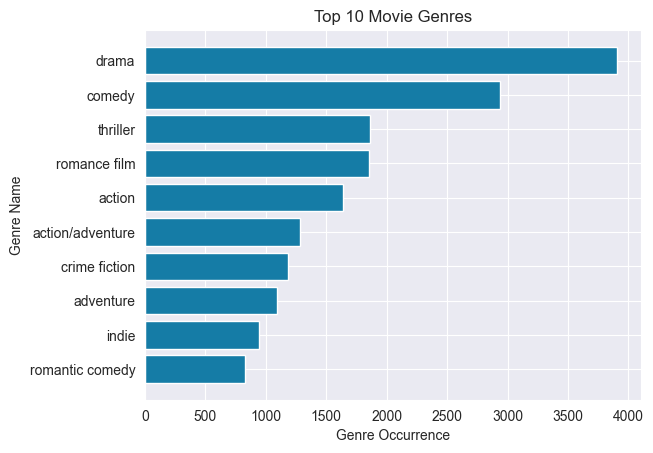

<Figure size 640x480 with 0 Axes>

In [86]:
import matplotlib.pyplot as plt
df = pd.read_csv("./data/GenreInfo.csv")
# Sort the dataframe by Genre Occurrence in descending order
df_sorted = df.sort_values(by='Genre Occurrence', ascending=False)

# Select the top 10 genres
top_20_genres = df_sorted.head(10).sort_values(by='Genre Occurrence', ascending=True)

# Plotting the top 10 genres
plt.barh(top_20_genres['Genre Name'], top_20_genres['Genre Occurrence'], color='#157CA6')
plt.ylabel('Genre Name')
plt.xlabel('Genre Occurrence')
plt.title('Top 10 Movie Genres')
plt.show()
plt.savefig('name.eps', format = 'eps')

Plotting the top languages from the dataset

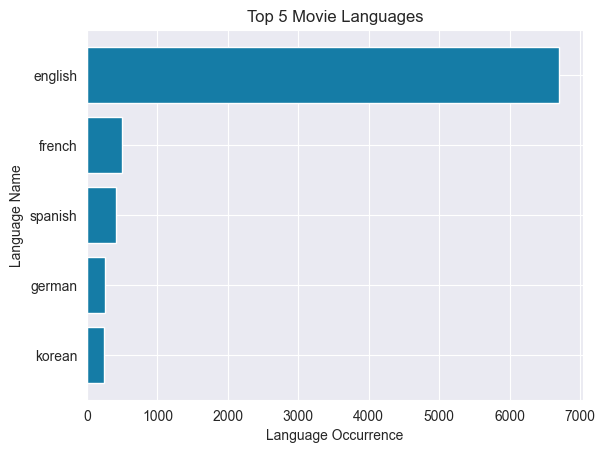

In [87]:
import matplotlib.pyplot as plt
df = pd.read_csv("./data/LanguageInfo.csv")
# Sort the dataframe by language Occurrence in descending order
df_sorted = df.sort_values(by='Language Occurrence', ascending=False)

# Select the top 5 genres
top_20_genres = df_sorted.head(5).sort_values(by='Language Occurrence', ascending=True)

# Plotting the top 5 genres
plt.barh(top_20_genres['Language Name'], top_20_genres['Language Occurrence'], color='#157CA6')
plt.ylabel('Language Name')
plt.xlabel('Language Occurrence')
plt.title('Top 5 Movie Languages')
plt.show()

Plotting the top Countries for Movie Production

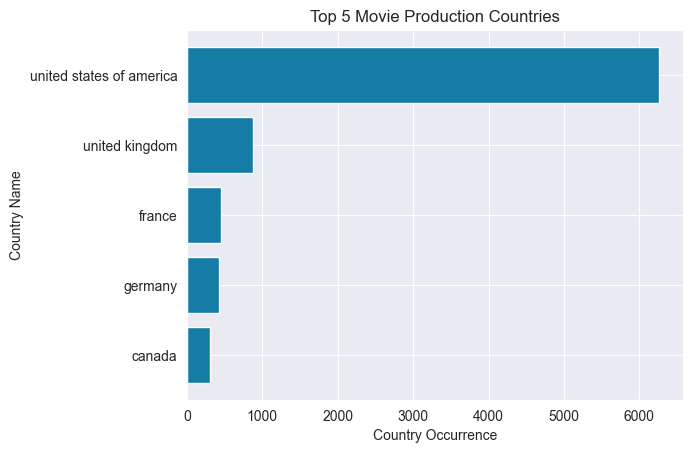

In [88]:
import matplotlib.pyplot as plt
df = pd.read_csv("./data/CountryInfo.csv")
# Sort the dataframe by country Occurrence in descending order
df_sorted = df.sort_values(by='Country Occurrence', ascending=False)

# Select the top 5 countries
top_20_genres = df_sorted.head(5).sort_values(by='Country Occurrence', ascending=True)

# Plotting the top 5 countries
plt.barh(top_20_genres['Country Name'], top_20_genres['Country Occurrence'], color='#157CA6')
plt.ylabel('Country Name')
plt.xlabel('Country Occurrence')
plt.title('Top 5 Movie Production Countries')
plt.show()

### Method 2: The next approach was to apply BOW (Bag of Words) and TF-IDF (Term Frequency - Inverse Document Frequency) over the movie plots. Since the dimensions of these embeddings were too large, we decided to apply SVD (singular value decomposition)


In [89]:
import nltk
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import ssl
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/priyankajain/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [90]:
lemmatizer = WordNetLemmatizer()

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('omw-1.4')
nltk.download('wordnet')

# Function for clean the given text by removing stopwords and lemmatization
def clean_text(text):

    plot_words = nltk.word_tokenize(text)
    # Removal of word
    punctutation_free_words = []
    for word in plot_words:
        if word.isalpha():
            punctutation_free_words.append(word.lower())

    # Stopwords Removal
    stop_words = set(stopwords.words('english'))
    stop_word_free_words = []
    for word in punctutation_free_words:
        if word not in stop_words:
            stop_word_free_words.append(word)

    # Lemmatization of the words
    lemmatized_words = [lemmatizer.lemmatize(word) for word in stop_word_free_words]
    return ' '.join(lemmatized_words)


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/priyankajain/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/priyankajain/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/priyankajain/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/priyankajain/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [91]:
def visualize_bow_features(bow_dataframe):
    """
    Visualize Bag of Words (BOW) features using Word Cloud.
    
    Parameters:
    - bow_dataframe: DataFrame containing BOW features.
    """
    print("Visualizing the features from Bag of Words (BOW)...")
    
    # Generate Word Cloud from BOW frequencies
    wc = WordCloud(
        background_color="white",
        width=1000,
        height=1000,
        max_words=100,
        relative_scaling=0.5,
        normalize_plurals=False
    ).generate_from_frequencies(bow_dataframe.sum())
    
    # Display Word Cloud
    plt.imshow(wc)
    plt.show()

In [92]:
# nltk.download('punkt')
df = pd.read_csv("./data/FinalDataset.csv")
print(df.columns)
row_count = df.shape[0]
print("Total Number of Records are: ", row_count)


Index(['Movie_ID', 'Movie_Name', 'Movie_Runtime', 'Movie_Plot',
       'Movie_Revenue_Category', 'english', 'afrikaans', 'spanish', 'korean',
       'romani',
       ...
       'alien invasion', 'british new wave', 'gay pornography',
       'supermarionation', 'essay film', 'period horror',
       'the netherlands in world war ii', 'revisionist fairy tale',
       'goat gland', 'Movie_Release_Year'],
      dtype='object', length=538)
Total Number of Records are:  7483


In [93]:
def extract_bow_and_tf_idf_fetaures(plots):
    """
    Perform feature extraction on given plots applying bag of words and tf idf.
    
    Parameters:
    - plots: Input 'Cleaned_Movie_Plot' column.
    
    Returns:
    - Transformed DataFrame after feature engineering.
    """
    print(plots)
    print("Applying Bag of Words (BOW) for feature extraction...")
    vectorizer = CountVectorizer(ngram_range=(1,1))
    bow_transform = vectorizer.fit_transform(plots)
    bow_features_df = pd.DataFrame(bow_transform.toarray(), columns=vectorizer.get_feature_names_out())
    print("Bag of Words (BOW) applied.")
    print(bow_features_df.head())

    visualize_bow_features(bow_features_df)

    print("Applying TF-IDF for feature extraction...")
    transformer = TfidfTransformer()
    tfidf_transform = transformer.fit_transform(bow_features_df)
    tf_idf_df = pd.DataFrame(tfidf_transform.toarray(), columns=vectorizer.get_feature_names_out())
    print("TF-IDF applied.")
    print(tf_idf_df.head())

    return tf_idf_df

def feature_engineer(df):
    """
    Perform feature engineering on the given DataFrame.
    
    Parameters:
    - df: Input DataFrame containing 'Movie_Plot' column.
    
    Returns:
    - Transformed DataFrame after feature engineering.
    """
    print("Feature engineering...")
    print(df.head())
    df['Cleaned_Movie_Plot'] = df['Movie_Plot'].apply(clean_text)
    
    feature_df = extract_bow_and_tf_idf_fetaures(df['Cleaned_Movie_Plot'])

    print("Applying Singular Value Decomposition (SVD) for Latent Semantic Analysis (LSA)...")
    svd = TruncatedSVD(n_components=400, n_iter=2, random_state=42)
    svd_transform_array = svd.fit_transform(feature_df)
    svd_dataframe = pd.DataFrame(svd_transform_array)
    print("SVD applied.")
    print(svd_dataframe.head())

    return svd_dataframe


Feature engineering...
   Movie_ID              Movie_Name  Movie_Runtime  \
0    975900          Ghosts of Mars           98.0   
1    171005                 Henry V          137.0   
2     77856            Mary Poppins          139.0   
3    156558                Baby Boy          123.0   
4    261237  The Gods Must Be Crazy          109.0   

                                          Movie_Plot Movie_Revenue_Category  \
0  Set in the second half of the 22nd century, th...               High_Med   
1  {{Plot|dateAct 1Act 2Act 3Act 4Act 5 Finally n...                Low_Med   
2  The phonograph winds up, and the needle touche...                   High   
3  A young 20-year-old named Jody  lives with his...               High_Med   
4  The film is a collision of three separate stor...               High_Med   

   english  afrikaans  spanish  korean  romani  ...  alien invasion  \
0        1          0        0       0       0  ...               0   
1        1          0        0     

0       set second half century film depicts mar plane...
1       finally negotiation made henry named king engl...
2       phonograph wind needle touch record lawn surro...
3       young named jody life mother juanita amg movie...
4       film collision three separate journey bushman ...
                              ...                        
7478    film open oscar wilde visit leadville colorado...
7479    film two teenage runaway nicky marotta poor fa...
7480    space armada mar known imperial atomic space n...
7481    havoc wrought inhabitant small new england tow...
7482    two family stay identical bungalow adjacent tr...
Name: Cleaned_Movie_Plot, Length: 7483, dtype: object
Applying Bag of Words (BOW) for feature extraction...
Bag of Words (BOW) applied.
   aa  aaa  aakash  aames  aang  aap  aardvark  aaron  aaronow  aaronson  ...  \
0   0    0       0      0     0    0         0      0        0         0  ...   
1   0    0       0      0     0    0         0      0        0  

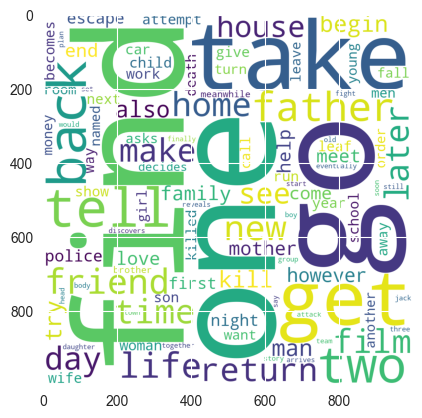

Applying TF-IDF for feature extraction...
TF-IDF applied.
    aa  aaa  aakash  aames  aang  aap  aardvark  aaron  aaronow  aaronson  \
0  0.0  0.0     0.0    0.0   0.0  0.0       0.0    0.0      0.0       0.0   
1  0.0  0.0     0.0    0.0   0.0  0.0       0.0    0.0      0.0       0.0   
2  0.0  0.0     0.0    0.0   0.0  0.0       0.0    0.0      0.0       0.0   
3  0.0  0.0     0.0    0.0   0.0  0.0       0.0    0.0      0.0       0.0   
4  0.0  0.0     0.0    0.0   0.0  0.0       0.0    0.0      0.0       0.0   

   ...  пре  рођења  сестрa  умро  過而不改是謂過矣  늦어서  미안해   영화  ﬁnd  ﬁrst  
0  ...  0.0     0.0     0.0   0.0       0.0  0.0  0.0  0.0  0.0   0.0  
1  ...  0.0     0.0     0.0   0.0       0.0  0.0  0.0  0.0  0.0   0.0  
2  ...  0.0     0.0     0.0   0.0       0.0  0.0  0.0  0.0  0.0   0.0  
3  ...  0.0     0.0     0.0   0.0       0.0  0.0  0.0  0.0  0.0   0.0  
4  ...  0.0     0.0     0.0   0.0       0.0  0.0  0.0  0.0  0.0   0.0  

[5 rows x 55714 columns]
Applying Singular Val

In [94]:
result_df = feature_engineer(df)
result_df.to_csv('./data/MoviePlotFeatures.csv')
print(result_df.head())

### Method 3 : Alternatively then we tried to add one more feature that is assigning the decomposed features a cluster among 4, and add it as a feature. The clustering was carried out using K-Means Clustering. The metrics for clustering such as Silhouette Score is mentioned below.

In [95]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score,pairwise_distances
import seaborn as sns
sns.set_style('darkgrid')

import pandas as pd

In [96]:
# Read Final Dataset and Movie Plot Features CSV files
finalDataset_df = pd.read_csv("./data/FinalDataset.csv")
moviePlot_df = pd.read_csv("./data/MoviePlotFeatures.csv")
# Drop unnecessary columns from Final Dataset
finalDataset_df_copy = finalDataset_df.drop(columns=['Movie_ID', 'Movie_Plot', 'Movie_Revenue_Category', 'Movie_Name'])

# Concatenate DataFrames
new_df = pd.concat([finalDataset_df_copy, moviePlot_df], axis=1)

In [97]:
df1 = new_df[new_df.isna().any(axis=1)]
df1
new_df.shape

(7483, 935)

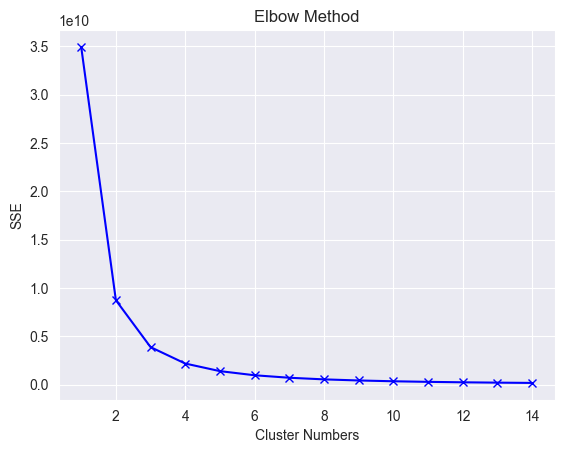

In [98]:
# Calculate SSE for different values of k
SSE = []
for k in range(1, 15):
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(new_df)
    SSE.append(kmeans.inertia_)

# Plot SSE against number of clusters
plt.plot(range(1, 15), SSE, 'bx-')
plt.title('Elbow Method')
plt.xlabel('Cluster Numbers')
plt.ylabel('SSE')
plt.show()

In [102]:
# Selecting k=4 clusters
kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=10, random_state=0)
clusters = kmeans.fit_predict(new_df)

# Add cluster feature to the final dataset
finalDataset_df["Cluster_Feature"] = clusters

# Concatenate final dataset with movie plot features
clusterFeature_df = pd.concat([finalDataset_df, moviePlot_df], axis=1)
clusterFeature_df.to_csv('./data/ClusterFeatures.csv')
 
silhouette_avg = silhouette_score(new_df, clusters)
print("The average silhouette score is :", silhouette_avg)

# Calculate the Calinski-Harabasz index
ch_score = calinski_harabasz_score(new_df, clusters)
print("The Calinski-Harabasz index is :", ch_score)

# Calculate the average distance between each point and its cluster centroid
closeness = []
for i in range(4):
    cluster_points = new_df[clusters == i]
    centroid = kmeans.cluster_centers_[i]
    dist = pairwise_distances(cluster_points, [centroid])
    closeness.append(dist.mean())

# Calculate the distance between each pair of cluster centroids
separation = pairwise_distances(kmeans.cluster_centers_)

# Calculate mean closeness and separation
mean_closeness = sum(closeness) / len(closeness)
mean_separation = separation.mean()

# Print the results
print(f"Closeness within Clusters: {mean_closeness}")
print(f"Separation between Clusters: {mean_separation}")

The average silhouette score is : 0.5698997846179551
The Calinski-Harabasz index is : 37266.023045140886
Closeness within Clusters: 469.5521243690184
Separation between Clusters: 2338.312769812946


## Proposed method

#### We worked on feature extraction from the textual data and then do classification. We then came to our final approach which is using a neural network model defined on top of BERT embeddings for revenue classification. It takes BERT embeddings from genre, movie plots and language and applies a fully connected layer for classification. 


In [2]:
df = pd.read_csv("./data/movie.metadata.tsv", sep ='\t', header= None)
df.columns = ['Movie_ID','Freebase_Movie_ID','Movie_Name','Movie_Release_Date','Movie_Box_Office_Revenue','Movie_Runtime','Movie_Languages','Movie_Countries','Movie_Genres']
df.dropna(inplace=True)
# getting number of rows in dataset
rows = df.shape[0]
print('Number of Records: ',rows)

Number of Records:  8243


In [3]:

# Working on fetching the movie plot into dataframe
moviePlotFile = './data/plot_summaries.txt'

with open(moviePlotFile, "r", encoding="utf8") as file:
    moviePlotFileLineList = [line for line in file]
# Now moviePlotFileLineList contains all the lines from the file

moviePlotList = []

for row in df['Movie_ID']:
    plotLine = next((line for line in moviePlotFileLineList if str(row) in line), None)
    if plotLine:
        _, _, plot = plotLine.partition('\t')
        plot = plot.replace("\n", "").replace("\\", "").strip()
        moviePlotList.append(plot)
    else:
        moviePlotList.append('')

df["Movie_Plot"] = moviePlotList
df["Movie_Plot"].head()

0     Set in the second half of the 22nd century, th...
7                                                      
13    {{Plot|dateAct 1Act 2Act 3Act 4Act 5 Finally n...
17    The phonograph winds up, and the needle touche...
21                                                     
Name: Movie_Plot, dtype: object

In [4]:
df.drop(columns=['Freebase_Movie_ID','Movie_ID'], inplace=True)
df['Movie_Language'] = ['' for x in range(len(df))]
df['Movie_Genre'] = ['' for x in range(len(df))]

In [5]:
# Clean up Movie_Languages column
df['Movie_Languages_Dict'] = df['Movie_Languages'].apply(lambda row: {key: value.lower()
                                                .replace("language","").strip() for key, value in json.loads(row).items()})
for index, row in df.iterrows():
    r = row['Movie_Languages_Dict']
    l = ''
    for language in r.values():
        l += language + ' '
    df.loc[index, 'Movie_Language'] = l

In [6]:
# Clean up Movie_Genres column
df['Movie_Genres_Dict'] = df['Movie_Genres'].apply(lambda row: {key: value.lower() for key, value in json.loads(row).items()})
for index, row in df.iterrows():
    r = row['Movie_Genres_Dict']
    g = ''
    for genre in r.values():
        g += genre + ' '
    df.loc[index, 'Movie_Genre'] = g

for index, row in df.iterrows():
    df.loc[index, 'Movie_Plot_combined'] = row['Movie_Genre'] + row['Movie_Language'] + "." + row['Movie_Plot']

# Bin movie box office revenue and obtain bins
df['Movie_Revenue_Category'], cutbin = pd.qcut(df['Movie_Box_Office_Revenue'], 4, \
                                               labels=['Low','Low_Med','High_Med','High'], retbins=True)

n_df = df[['Movie_Revenue_Category', "Movie_Plot_combined"]]
df = n_df
df.rename(columns={'Movie_Plot_combined': 'Movie_Plot'}, inplace=True)
df.to_csv('./data/DataForModel.csv')


In [7]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

In [8]:
lemmatizer = WordNetLemmatizer()
# Function to clean the text
def clean_text(text):
    plot_words = nltk.word_tokenize(text)
    punctutation_free_words = [word.lower() for word in plot_words if word.isalpha()]
    stop_words = set(stopwords.words('english'))
    stop_word_free_words = [word for word in punctutation_free_words if word not in stop_words]
    lemmatized_words = [lemmatizer.lemmatize(word) for word in stop_word_free_words]
    return ' '.join(lemmatized_words)

# Load data
df1 = pd.read_csv('./data/DataForModel.csv')
df1['Movie_Plot'] = df1['Movie_Plot'].apply(clean_text)
df = df1[['Movie_Plot', 'Movie_Revenue_Category']]

#### Training the model

In [9]:
import argparse
import os
import pandas as pd
import torch
import torch.nn as nn
from transformers import BertModel, BertTokenizer
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

/Users/priyankajain/nlpclass-1241-g-NeuralNarratives/project/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
df1 = pd.read_csv('./data/DataForModel.csv')
df1['Movie_Plot'] = df1['Movie_Plot'].apply(clean_text)
df = df1[['Movie_Plot', 'Movie_Revenue_Category']]

# Encode labels and tokenize plots
label_encoder = LabelEncoder()
df['Encoded_Labels'] = label_encoder.fit_transform(df['Movie_Revenue_Category'])
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
label_encoder = LabelEncoder()
df['Encoded_Labels'] = label_encoder.fit_transform(df['Movie_Revenue_Category'])
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [11]:
class MovieDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=512):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        plot = str(self.data.iloc[index]['Movie_Plot'])
        label = self.data.iloc[index]['Encoded_Labels']
        inputs = self.tokenizer.encode_plus(
            plot,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return {
            'input_ids': inputs['input_ids'].squeeze(0),
            'attention_mask': inputs['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [13]:
# Split data into train and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Create DataLoader for training and testing
train_dataset = MovieDataset(train_df, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset = MovieDataset(test_df, tokenizer)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize BERT model
bert_model = BertModel.from_pretrained('bert-base-uncased').to(device)

In [14]:
class RevenuePredictionModel(nn.Module):
    def __init__(self, bert_model, num_classes):
        super(RevenuePredictionModel, self).__init__()
        self.bert = bert_model
        self.fc = nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        logits = self.fc(pooled_output)
        return logits

# Initialize the model and other training parameters
num_classes = len(label_encoder.classes_)
model = RevenuePredictionModel(bert_model, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
num_epochs = 5

#### Training of this model was done on CSIL. The model is directly loaded from it's location

In [15]:
model.load_state_dict(torch.load('./model.pt',map_location=torch.device('cpu')))

<All keys matched successfully>

In [16]:
model

RevenuePredictionModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

## Evaluation

### Baseline

In [17]:
import pandas as pd
import re 
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_predict, GridSearchCV
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.manifold import TSNE
from sklearn.model_selection import KFold, StratifiedKFold, ShuffleSplit

In [18]:
# Applying model with the cross validation technique
def apply_model_with_cross_validation(model, independent_variables, dependent_variable, folds):
    # skfold = StratifiedKFold(n_splits=folds, shuffle=True)
    results = cross_val_predict(estimator=model, X=independent_variables, y=dependent_variable,cv=folds)
    conf_mat = confusion_matrix(dependent_variable, results)
    class_rep = classification_report(dependent_variable, results)
    return {"Classification Report": class_rep,"Confusion Matrix": conf_mat,"Prediction Results": results}

def train_test(X,Y):
    # Creating Gaussian Naive Bayes classifier to be applied
    model = GaussianNB()
    print("Using Gaussian Naive Bayes classifier...")
    result = apply_model_with_cross_validation(model, X, Y, 10)
    print(result["Classification Report"])
    print(result["Confusion Matrix"])

In [19]:
def get_X_Y():
    label_encoder = LabelEncoder()
    df = pd.read_csv("./data/FinalDataset.csv")
    regex = re.compile(r"\[|\]|<", re.IGNORECASE)
    df.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in df.columns.values]

    Y = label_encoder.fit_transform(df['Movie_Revenue_Category'])
    df = df.drop(columns=[ 'Movie_ID', 'Movie_Plot', 'Movie_Name','Movie_Revenue_Category'])
    return df, Y

X,Y=get_X_Y()
train_test(X,Y)
    

Using Gaussian Naive Bayes classifier...
              precision    recall  f1-score   support

           0       0.53      0.16      0.25      1871
           1       0.28      0.79      0.42      1870
           2       0.50      0.38      0.43      1871
           3       0.23      0.03      0.06      1871

    accuracy                           0.34      7483
   macro avg       0.39      0.34      0.29      7483
weighted avg       0.39      0.34      0.29      7483

[[ 306 1379  122   64]
 [ 115 1477  212   66]
 [  43 1026  720   82]
 [ 109 1301  399   62]]


### Method 2

In [20]:
def get_X_Y():
    label_encoder = LabelEncoder()
    df1 = pd.read_csv("./data/FinalDataset.csv")
    df = pd.read_csv("./data/MoviePlotFeatures.csv")
    regex = re.compile(r"\[|\]|<", re.IGNORECASE)
    df.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in df.columns.values]

    Y = label_encoder.fit_transform(df1['Movie_Revenue_Category'])
    return df, Y

X,Y=get_X_Y()
train_test(X,Y)

Using Gaussian Naive Bayes classifier...
              precision    recall  f1-score   support

           0       0.16      0.00      0.01      1871
           1       0.31      0.03      0.06      1870
           2       0.25      0.96      0.40      1871
           3       0.21      0.02      0.04      1871

    accuracy                           0.25      7483
   macro avg       0.24      0.25      0.13      7483
weighted avg       0.24      0.25      0.13      7483

[[   5   66 1733   67]
 [  13   60 1761   36]
 [   6   32 1804   29]
 [   7   35 1793   36]]


### Method 3

In [21]:
def get_X_Y():
    label_encoder = LabelEncoder()
    df = pd.read_csv("./data/ClusterFeatures.csv")

    regex = re.compile(r"\[|\]|<", re.IGNORECASE)
    df.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in df.columns.values]

    Y = label_encoder.fit_transform(df['Movie_Revenue_Category'])
    df = df.drop(columns=[ 'Movie_ID', 'Movie_Plot', 'Movie_Name','Movie_Revenue_Category'])
    return df, Y

X,Y=get_X_Y()
train_test(X,Y)

Using Gaussian Naive Bayes classifier...
              precision    recall  f1-score   support

           0       0.55      0.35      0.43      1871
           1       0.35      0.32      0.33      1870
           2       0.37      0.71      0.48      1871
           3       0.29      0.15      0.20      1871

    accuracy                           0.38      7483
   macro avg       0.39      0.38      0.36      7483
weighted avg       0.39      0.38      0.36      7483

[[ 653  527  504  187]
 [ 271  605  732  262]
 [  78  233 1320  240]
 [ 176  383 1025  287]]


### Final Approach Evaluation

In [22]:
true_labels = []
predicted_labels = []

# Evaluation loop
with torch.no_grad():
    for batch in tqdm(test_loader, desc='Testing'):
        input_ids, attention_mask, labels = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['label'].to(device)
        logits = model(input_ids, attention_mask)
        _, predicted = torch.max(logits, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

# Calculate evaluation metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Testing: 100%|██████████| 52/52 [14:23<00:00, 16.60s/it]

Accuracy: 0.4651
Precision: 0.4507
Recall: 0.4651
F1 Score: 0.4458


## Results

These were the results, where we can see we got the best results for Neural Network Model, where in we trained a neural network model over the bert embeddings, its parameters were 5 epochs, 1e-5 learning rate and 32 batch size and with that we achieved an accuracy of .46 and F1 score of .44 which is a significant improvement over the baseline. 
